### Imports and setup

In [1]:
from fastai.imports import *
from fastai.vision import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.functional as F

import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

In [2]:
from fastai.vision.models.unet import _get_sfs_idxs, hook_output, model_sizes

In [3]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"

In [4]:
def get_img_id(fname):
    fname = fname.replace('_RGB.tif', '')
    img_id = "_".join(fname.split('_')[:-1])
    return img_id

train_img_ids = [get_img_id(f.name) for f in cropped_dir.ls() if f.name.endswith('RGB.tif')]
val_img_ids = [get_img_id(f.name) for f in cropped_val_dir.ls() if f.name.endswith('RGB.tif')]

### create the correct label files for object detection masks

In [5]:
labels_train_dir = data_dir / "cropped_training_labels"
labels_train_dir.mkdir(exist_ok=True)

labels_val_dir = data_dir / "cropped_validation_labels"
labels_val_dir.mkdir(exist_ok=True)

In [6]:
def parse_label(arr, label_val):
    """
    convert the _GTI instance segmentation masks to YOLO format (x, y, w, h) where
    x = 0.5 * (x1 + x2) and y = 0.5 * (y1 + y2)
    """
    item = np.argwhere(arr==label_val)
    y1, y2, x1, x2 = item[:,0].min(), item[:,0].max(), item[:,1].min(), item[:,1].max()
    x = int(0.5 * (x1+ x2))
    y = int(0.5 * (y1+y2) )
    w = x2 -x1
    h = y2-y1
    return x, y, w, h
def label_to_str(label_out_tuple):
    return " ".join(list(map(str, label_out_tuple)))

def parse_img(img_fname, dataset_type="training"):
    label_img = sktif.imread(str(data_dir / f"cropped_{dataset_type}"/ img_fname))
    label_filepath =data_dir / f"cropped_{dataset_type}_labels/{img_fname.replace('.tif', '.txt')}"
    max_label = label_img.max()
    
    min_label = np.min(label_img[np.nonzero(label_img)]) if max_label > 0 else 0
    valid_labels = [x for x in range(min_label, max_label + 1) if len(np.where(label_img == x)[0]) > 0]
    
    with open(label_filepath, 'w') as f:
        [f.write(f"{img_fname.replace('.tif','')} {label_to_str(parse_label(label_img, label_val))}\n") \
         for label_val in valid_labels]
    
    
    

In [7]:
cropped_train_fnames =[f.name for f in ( data_dir / "cropped_training").ls() if f.name.endswith('GTI.tif')]
cropped_val_fnames =[f.name for f in ( data_dir / "cropped_validation").ls() if f.name.endswith('GTI.tif')]

In [58]:
%time out=[parse_img(fname) for fname in cropped_train_fnames]

CPU times: user 17.5 s, sys: 208 ms, total: 17.7 s
Wall time: 26.9 s


In [59]:
%time out=[parse_img(fname,  dataset_type="validation") for fname in cropped_val_fnames]

CPU times: user 3.68 s, sys: 16.6 ms, total: 3.69 s
Wall time: 5.83 s


Fastai object detection example
```python
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   ```

### Create datablock for object segmentation

In [8]:
label_filepaths =[data_dir / "cropped_training_labels"/f"{img_fname.replace('.tif', '.txt')}" for img_fname in cropped_train_fnames]

In [9]:
validation_label_filepaths =[data_dir / f"cropped_validation_labels/{img_fname.replace('.tif', '.txt')}" for img_fname in cropped_val_fnames]

In [10]:
def parse_label_file(fpath):
    """
    convert yolo labels back to the fastai/numpy format 
    """
    df = pd.read_csv(fpath, header=None, sep=" ", names=['id', 'x', 'y', 'w', 'h'])
    df['output'] = df.apply(lambda row: [row.y-row.h/2, row.x-row.w/2, row.h/2 + row.y, row.x + row.w/2], axis=1)
    return [list(df["output"]), ['building'] * len(df['output'])]

In [11]:
train_labels_bbox = [parse_label_file(f) for f in label_filepaths]


In [12]:
val_labels_bbox = [parse_label_file(f) for f in validation_label_filepaths]


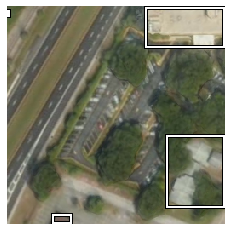

In [12]:

img = open_image(data_dir / "cropped_training"/ cropped_train_fnames[1].replace('GTI', 'RGB'))
bbox = ImageBBox.create(*img.size, train_labels_bbox[1][0])
img.show(figsize=(6,4), y=bbox)

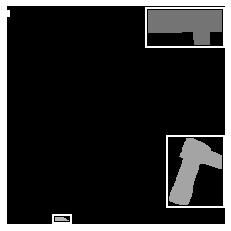

In [13]:
# sanity check-- the boxes are indeed where we expect them to be
img = open_image(data_dir / "cropped_training"/ cropped_train_fnames[1])
img.show(figsize=(6,4), y=bbox)

In [13]:
train_img_names = [f.name.replace('GTI', 'RGB').replace('txt', 'tif') for f in label_filepaths]
valid_img_names = [f.name.replace('GTI', 'RGB').replace('txt', 'tif') for f in validation_label_filepaths]

img_names = train_img_names + valid_img_names
bboxes = train_labels_bbox + val_labels_bbox

assert len(img_names) == len(bboxes)

In [14]:
img2bbox = dict(zip(img_names, bboxes))
get_y_func = lambda o:img2bbox[o.name]

In [15]:
def get_data(size=128, bs=32):
    """
    create databunch
    """
    src = (ObjectItemList.from_folder(data_dir)
            .filter_by_func(lambda fname: Path(fname).name.endswith('RGB.tif'))
            .split_by_folder(train="cropped_training", valid="cropped_validation")
           .label_from_func(get_y_func)
           .transform(get_transforms(do_flip=True, 
                                     
                 flip_vert=True, 
                 max_rotate=180, 
                 max_zoom=1.2, 
                 max_lighting=0.5,
                 max_warp=0.2, 
                 p_affine=0.75, 
                 p_lighting=0.75), size=size,  tfm_y=True)
            .databunch(bs=bs, collate_fn = bb_pad_collate)
          )
    return src


In [16]:
data = get_data()

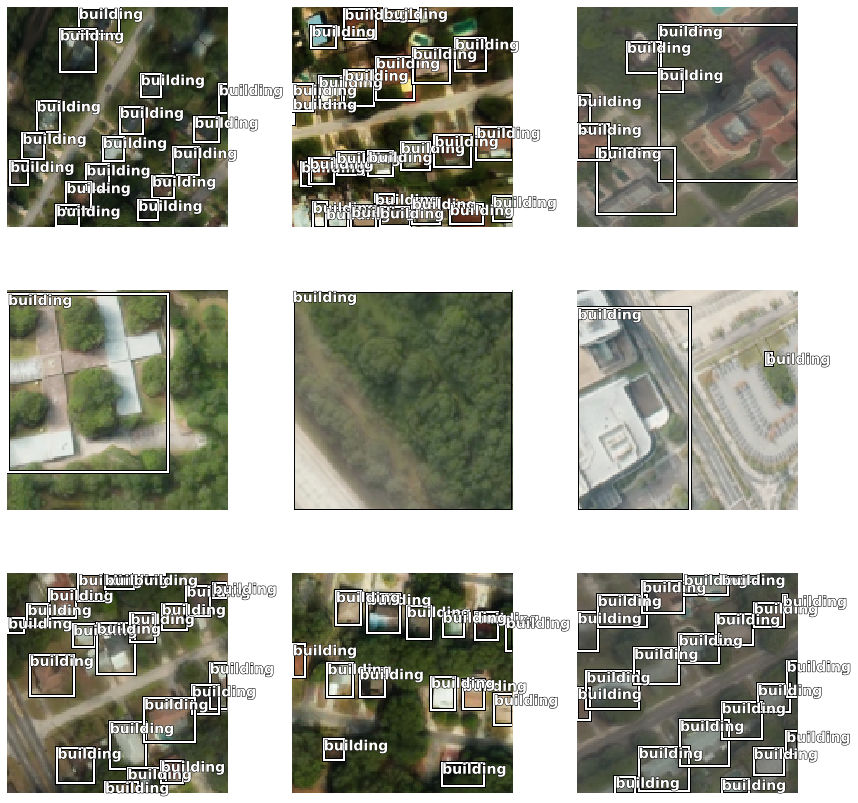

In [17]:
data.show_batch(rows=3)

### Modelling

similr to the focal loss paper, use a retinanet

the `_get_sfs_idxs` function grabs all the layer indexes where the unet 'shrinks' 

In [18]:
class LateralUpsampleMerge(nn.Module):
    """
    implements the structure from fig 3 from https://arxiv.org/pdf/1612.03144.pdf (see below)
    """
    def __init__(self, channel_c, channel_out, hook):
        super().__init__()
        # hooks: a gradient with respect to the tensor is computed the hook will be called.
        self.hook = hook
        self.conv_lateral_merge = conv2d(channel_c, channel_out, ks=1) # -> the 1x1 conv
        
    def forward(self, x ):
        """
        the interpolate function does the upsampling-- and same as the paper uses the nearest neighbour mode
        """
        merge = sself.conv_lateral_merge(self.hook.stored) + \
                F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

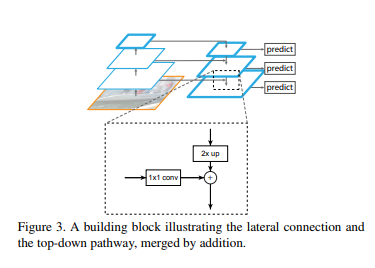

In [19]:
from IPython.display import Image
Image("/home/wwymak/Pictures/Screenshot from 2019-07-25 21-49-26.png")

In [ ]:
class RetinaNet(nn.Module):
    def __init__(self, encoder, n_classes,  img_size=256, final_bias=0., 
                 channels=256, # common number of channels for the features pyramids, in the paper this is 256
                 n_anchors=9, flatten=True):
        super().__init__()
        self.encoder = encoder # e.g. ResNet50 , the backbone
        self.n_classes  = n_classes # in this case it's only 1 for buildings
        # figure out the shape of the features layers when it changes shape
        self.final_bias = final_bias
        self.encoder_layer_sizes = model_sizes(encoder, size=img_size) 
        self.channels = channels
        self.n_anchors = n_anchors
        self.flatten = flatten
        
    def forward(self, x):
        c5 = self.encoder(x)
        feature_states = 
        
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [30]:
model_sizes(create_body(models.resnet50, cut=-2), size=(256,256))

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 256, 64, 64]),
 torch.Size([1, 512, 32, 32]),
 torch.Size([1, 1024, 16, 16]),
 torch.Size([1, 2048, 8, 8])]

In [26]:
models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co